In [1]:
import pandas as pd
import sklearn
import pickle
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer  
from sklearn.feature_extraction.text import TfidfVectorizer
import json
import plotly.express as px
from pprint import pprint
import spacy #used for lemmatization
nltk.download('stopwords')
import pyLDAvis.gensim_models
import gensim.corpora as corpora
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import ldaseqmodel
import zipfile
import warnings
warnings.filterwarnings('ignore')
stop_words=set(nltk.corpus.stopwords.words('english'))


!python -m spacy download en_core_web_sm
pd.set_option('display.max_colwidth', None) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.1 MB/s eta 0:00:0000:010:01m
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
#Please run these pip install if this is the first time you run this notebook and you don't have the package below installed.
# !pip install wordcloud
# !pip install gensim
# !pip install -U spacy[cuda113]
# !pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 KB 11.2 MB/s eta 0:00:0000:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 20.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 KB 15.6 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 33.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 KB 5.4 M

In [5]:
#Read in the dataset
# import zipfile
# with zipfile.ZipFile('complaints-2022-10-23_09_54.csv.zip') as zip:
#     with zip.open('complaints-2022-10-23_09_54.csv') as myZip:
#         df = pd.read_csv(myZip) 
df=pd.read_csv('complaints-2022-10-23_09_54.csv')

In [7]:
#Keep top 5 companies as the datasize is too huge for the LDA model.
top5=df.groupby('Company')['Complaint ID'].count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
top5_company=top5.Company.to_list()
top5_df=df[df['Company'].isin(top5_company)]

In [12]:
top5_df['Date_received_dt'] = pd.to_datetime(top5_df['Date received'], format='%m/%d/%y')
top5_df['Date_sent_to_company_dt'] = pd.to_datetime(top5_df['Date sent to company'], format='%m/%d/%y')

In [13]:
top5_df['time_diff'] = top5_df['Date_sent_to_company_dt']-top5_df['Date_received_dt']
# The percentage of complaints that don't sent to the company on the same date.
len(top5_df[top5_df['time_diff']!='0 days'])/len(top5_df)*100

4.590168615525193

In [14]:
top5_df.reset_index
top5_df=top5_df.set_index('Complaint ID')
top5_df['Date sent to company_dt'] =  pd.to_datetime(top5_df['Date sent to company'], format='%m/%d/%y')
#top10_df_2018bf=df[df['Date sent to company_dt'].dt.year<=2018]

#### Cleaning step

- Make text all lower case
- Remove punctuation
- Remove numerical values
- Remove common non-sensical text (/n)
- Tokenize text
- Remove stop words
- Stemming / lemmatization
- Parts of speech tagging
- Create bi-grams or tri-grams

In [15]:
# Text cleaning - lowercase, remove punctuations and remove words with numbers. 

import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[x*\/]', '', text) #remove those dates with the format of XX/XX OR XXXX/XX/XX
    text = re.sub('x', '', text)#remove \n
    text = re.sub('\n', '', text)#remove \n
    return text

clean_step = lambda x: clean_text(x)

In [16]:
#Although we do not need to train and test in unsupervised, but we would like to leave some data out as unseen documents
df_train=top5_df.sample(frac=0.8, replace=False, random_state=42)
df_test=top5_df[~top5_df.index.isin(df_train.index)]

In [17]:
#We apply the clean step for the training dataset
data_clean = pd.DataFrame(df_train['Consumer complaint narrative'].apply(clean_step))
data_clean.head()

Consumer complaint narrative
Complaint ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
4911306                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ive submitted several disputes to the credit bureaus and to no avail have i received a response from the bureau s  equifa and neither  please help
3797983       eperian credit reporting agency  also  eperian information solutions inc  has mis represented information on my credit report for several months now and i have been diligent in my efforts to aid them in fiing however i just found out today that i was rejected for a vital eidl aid because they reported an inaccurate score to the sba they are the direct and proimate cause of loss and injury to myself and   phone records and recording will show that i tried many times to deal with the company on the matter however never gotten anywhere i am now seeking administrative remedy and will pursue punitive damages and recompensation for the harm cause to myself and   by the information agency and request that the cfpb intercede as to ensure there is no reprisal or further mismanagement or my record as a result of future proceedings the damage is directly related to the fact that eperian did not publish my student loan information and thereby produce a credit score the student loans are federal loan managed by  i spoke with  and they assured me that they report the loan information to all three major bureaus to include eperian the information reports correctly on  and  but not eperian i request swift action be taken
5328667                                                                                                                                                                                                                                                          

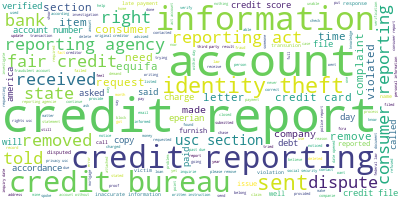

In [13]:
# Let's take a look at the wordcloud for our training dataset
long_string = ','.join(list(data_clean['Consumer complaint narrative'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### Now, let's clean up the text, and then create bi-gram or trigrams as banks has lots of terms that should appear together. 

In [148]:
#Let's remove stopwords, and based on the word cloud we saw, we add some additional stop word
stop_words = stopwords.words('english')
# I added some additional stop words based on the word cloud we just created.
stop_words.extend(['sent','told','received','said','asked','made','contacted','know','spoke','company','will','year','month'])

In [149]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [150]:
data = data_clean['Consumer complaint narrative'].values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['ive', 'submitted', 'several', 'disputes', 'to', 'the', 'credit', 'bureaus', 'and', 'to', 'no', 'avail', 'have', 'received', 'response', 'from', 'the', 'bureau', 'equifa', 'and', 'neither', 'please', 'help']


In [27]:
#Define some useful functions that could be used for data cleaning
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Define a function that creates bigrams
def bigrams(words, bi_min=15,threshold=100):
    bigram = gensim.models.Phrases(words, min_count = bi_min,threshold=threshold)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

#Define a function that creates trigrams
def trigrams(words, tri_min=15,threshold=100):
    bigram = gensim.models.Phrases(words, min_count=tri_min, threshold=threshold)
    trigram = gensim.models.Phrases(bigram[words],threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return bigram_mod

#Define a function that perform lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [ ]:
# Form Bigrams
bigram_mod = bigrams(data_words_nostops)
bigrams = [bigram_mod[w] for w in data_words_nostops]

In [ ]:
#I commented the trigrams part out, as after reviewing the trigram output, I realized that there are not lot of trigram in our complaint narratives
# Form Trigrams
# tri_mod = trigrams(data_words_nostops)
# trigram = [tri_mod[w] for w in data_words_nostops]

In [30]:
%%time
spacy.prefer_gpu() # or spacy.require_gpu()
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

/home/fangyf/.local/lib/python3.9/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value ['ner', 'parser'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


CPU times: user 635 ms, sys: 44.2 ms, total: 679 ms
Wall time: 1.94 s


#### I separated the data lemmatization into four parts, this is due to the limited computation power, and if they were combined, the kernel may die out. With more powerful computing resource, this could be done in one step.

In [44]:
%%time
# Perform lemmatization keeping only noun, adj, vb, adv
data_lemmatized_bigrams = lemmatization(bigrams[:100000], allowed_postags=['NOUN', 'ADJ'])
print(data_lemmatized_bigrams[:1][0][:30])

['several', 'dispute', 'credit']
CPU times: user 10min 15s, sys: 1.9 s, total: 10min 17s
Wall time: 10min 21s


In [24]:
%%time
data_lemmatized_bigrams2 = lemmatization(bigrams[100000:200000], allowed_postags=['NOUN', 'ADJ'])
print(data_lemmatized_bigrams2[:1][0][:30])

['delete', 'information', 'file', 'item', 'report', 'victim', 'identity', 'theft', 'charge', 'ask', 'item', 'correct', 'credit', 'report', 'theft', 'identity', 'federal', 'trade_commission', 'copy', 'federal', 'trade_commission', 'identity', 'theft', 'affidavit', 'item', 'possible', 'hindering', 'advance', 'life', 'house']
CPU times: user 10min 4s, sys: 1.9 s, total: 10min 6s
Wall time: 10min 10s


In [25]:
%%time
data_lemmatized_bigrams3 = lemmatization(bigrams[200000:300000], allowed_postags=['NOUN', 'ADJ'])
print(data_lemmatized_bigrams3[:1][0][:30])

['complaint', 'identification', 'fa', 'number', 'work', 'shady', 'dishonest', 'refuse', 'information', 'inaccurate', 'pay', 'service', 'report']
CPU times: user 10min 33s, sys: 4.48 s, total: 10min 38s
Wall time: 10min 42s


In [26]:
%%time
data_lemmatized_bigrams4 = lemmatization(bigrams[300000:], allowed_postags=['NOUN', 'ADJ'])
print(data_lemmatized_bigrams4[:1][0][:30])

['card', 'day', 'day', 'representative', 'dispute', 'claim', 'credit', 'bureau', 'correct', 'error']
CPU times: user 9min 24s, sys: 2.33 s, total: 9min 26s
Wall time: 9min 30s


In [54]:
#Combine all the lemmatized bigrams into one
data_lemmatized_bigrams.extend(data_lemmatized_bigrams2)
data_lemmatized_bigrams.extend(data_lemmatized_bigrams3)
data_lemmatized_bigrams.extend(data_lemmatized_bigrams4)

In [18]:
#Save the bigrams
# with open('data_lemmatized_bigrams.txt', 'w') as f:
#     f.write(json.dumps(data_lemmatized_bigrams))

#Read back the bigrams
with open('data_lemmatized_bigrams.txt', 'r') as f:
    data_lemmatized_bigrams = json.loads(f.read())

In [19]:
%%time
#Now let's get the id2word, and corpus.
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized_bigrams)
id2word.filter_extremes(no_below=10, no_above=0.5)
id2word.compactify()
# Create Corpus
texts = data_lemmatized_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1)]
CPU times: user 20.5 s, sys: 321 ms, total: 20.8 s
Wall time: 21 s


In [19]:
#Apply TFIDF Model
from gensim.models import TfidfModel
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

#### In the following step, I created LDA model on both Bag of words and TFIDF corpus and later decide which one is better to use

In [40]:
%%time
#Run LDA on Bag of Words
lda_model_bow_lem_5comp = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=id2word, passes=10,chunksize=100,
                           workers=7)

CPU times: user 2min 55s, sys: 29.8 s, total: 3min 25s
Wall time: 3min 15s


In [41]:
lda_model_bow_lem_5comp.save('lda_model_bow_lem_5comp.model')
with open('lda_model_bow_lem_5comp.pkl', 'wb') as f:
     pickle.dump(lda_model_bow_lem_5comp, f)

In [22]:
#load model 
lda_model_bow_lem_5comp = 'lda_model_bow_lem_5comp.pkl'
with open(lda_model_bow_lem_5comp, 'rb') as f:
    lda_model_bow_lem_5comp = pickle.load(f)  
    
#load id2word
id2word_dic='lda_model_bow_lem_5comp.model.id2word'
id2word_bow = corpora.Dictionary.load(id2word_dic)

# Recreate Corpus
texts = data_lemmatized_bigrams

# Term Document Frequency
corpus = [id2word_bow.doc2bow(text) for text in texts]



In [16]:
#Let's print out the top 10 topic model out of the BOW LDA model.
pprint(lda_model_bow_lem_5comp.print_topics())

[(0,
  '0.077*"claim" + 0.033*"collection" + 0.032*"reporting" + 0.027*"full" + '
  '0.025*"debt" + 0.024*"compliance" + 0.020*"knowledge" + 0.019*"compliant" + '
  '0.019*"document" + 0.015*"practice"'),
 (1,
  '0.037*"card" + 0.030*"chase" + 0.020*"bank" + 0.018*"money" + 0.017*"time" '
  '+ 0.015*"service" + 0.014*"phone" + 0.014*"charge" + 0.014*"call" + '
  '0.013*"check"'),
 (2,
  '0.084*"payment" + 0.049*"loan" + 0.036*"late" + 0.026*"score" + '
  '0.025*"time" + 0.020*"mortgage" + 0.017*"due" + 0.016*"year" + 0.012*"home" '
  '+ 0.011*"car"'),
 (3,
  '0.110*"identity" + 0.091*"theft" + 0.065*"fraudulent" + 0.042*"victim" + '
  '0.040*"item" + 0.027*"police" + 0.027*"information" + 0.021*"transunion" + '
  '0.019*"score" + 0.015*"record"'),
 (4,
  '0.084*"information" + 0.040*"letter" + 0.039*"dispute" + 0.034*"eperian" + '
  '0.031*"inaccurate" + 0.026*"reporting" + 0.023*"complaint" + 0.022*"item" + '
  '0.022*"investigation" + 0.021*"law"'),
 (5,
  '0.108*"inquiry" + 0.043*"n

In [ ]:
#Run LDA on TF-IDF
lda_model_tfidf_lem_5 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=id2word, passes=10,chunksize=100,
                           workers=7)

In [ ]:
#This step saved the model to the specified location
lda_model_tfidf_lem_5.save('lda_model_tfidf_lem_5.model')
with open('lda_model_tfidf_lem_5.pkl', 'wb') as f:
     pickle.dump(lda_model_tfidf_lem_5, f)

In [23]:
#load model
from gensim.models import TfidfModel 
lda_model_tfidf_lem_5 = 'lda_model_tfidf_lem_5.pkl'
with open(lda_model_tfidf_lem_5, 'rb') as f:
    lda_model_tfidf_lem_5 = pickle.load(f)  

In [24]:
#load id2word
id2word_dic_tfidf='lda_model_tfidf_lem_5.model.id2word'
id2word_tfidf = corpora.Dictionary.load(id2word_dic_tfidf)


# Term Document Frequency
corpus = [id2word_bow.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [21]:
#Let's print out the top 10 topic model out of the TFIDF LDA model.
pprint(lda_model_tfidf_lem_5.print_topics())

[(0,
  '0.119*"inquiry" + 0.040*"unauthorized" + 0.034*"hard" + 0.026*"inquire" + '
  '0.021*"company" + 0.018*"personal" + 0.016*"fraudulent" + '
  '0.016*"transunion" + 0.014*"date" + 0.013*"information"'),
 (1,
  '0.022*"collection" + 0.015*"debt" + 0.012*"medical" + 0.012*"claim" + '
  '0.010*"information" + 0.009*"possible" + 0.009*"compliance" + '
  '0.008*"compliant" + 0.007*"bill" + 0.007*"showing"'),
 (2,
  '0.031*"complaint" + 0.030*"filing" + 0.026*"d" + 0.021*"party" + '
  '0.020*"false" + 0.016*"behalf" + 0.014*"deposit" + 0.014*"boa" + '
  '0.012*"third" + 0.010*"error"'),
 (3,
  '0.033*"payment" + 0.025*"late" + 0.022*"loan" + 0.018*"balance" + '
  '0.016*"score" + 0.011*"date" + 0.010*"due" + 0.010*"status" + '
  '0.009*"mortgage" + 0.009*"full"'),
 (4,
  '0.044*"identity" + 0.042*"theft" + 0.029*"fraudulent" + 0.028*"victim" + '
  '0.019*"name" + 0.018*"police" + 0.015*"security" + 0.015*"fraud" + '
  '0.015*"item" + 0.014*"social"'),
 (5,
  '0.019*"consumer" + 0.015*"

Matplotlib is building the font cache; this may take a moment.


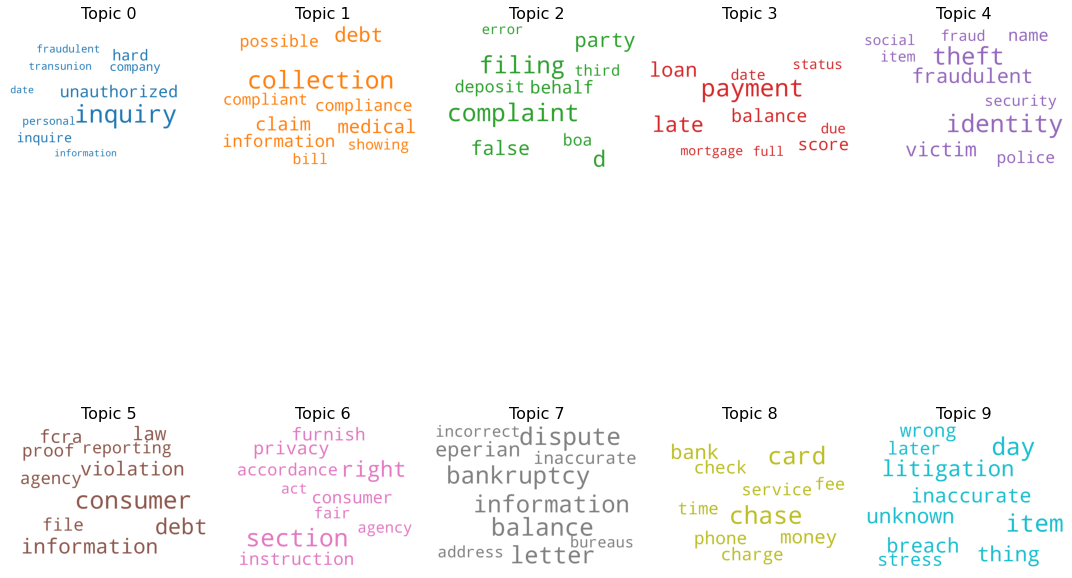

In [27]:
#Visualize the key words in each topics
# I get the idea of this visualization from a post: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf_lem_5.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [25]:
#Visualize the bag of words with top 10 topics using pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model_bow_lem_5comp, corpus, id2word)
pyLDAvis.display(vis)

In [26]:
#Visualize the tfidf with top 10 topics using pyLDAvis
vis2 = pyLDAvis.gensim_models.prepare(lda_model_tfidf_lem_5, corpus_tfidf, id2word)
pyLDAvis.display(vis2)

#### Next, let's see how the models perform, and pick the better model based on coherence value.

In [66]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,chunksize=100,
                           workers=7)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
%%time
coherencemodel_bow = CoherenceModel(model=lda_model_bow_lem_5comp, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherencemodel_bow.get_coherence()

-1.9108488229692984

In [64]:
%%time
coherencemodel_tfidf = CoherenceModel(model=lda_model_tfidf_lem_5, corpus=corpus_tfidf, dictionary=id2word, coherence='u_mass')
coherencemodel_tfidf.get_coherence()

CPU times: user 35.6 s, sys: 188 ms, total: 35.8 s
Wall time: 35.9 s


-2.2466021740921223

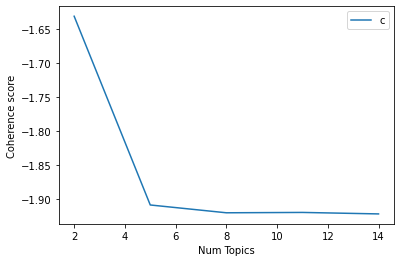

In [67]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=15, step=3)
# Show graph
import matplotlib.pyplot as plt
limit=16; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

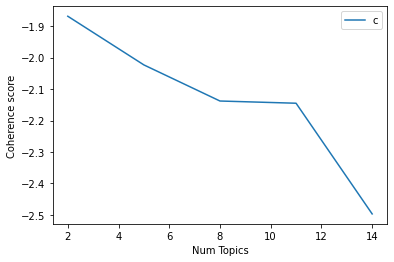

In [42]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=texts, start=2, limit=15, step=3)
# Show graph
import matplotlib.pyplot as plt
limit=16; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
#tfidf
best_result_index = coherence_values.index(min(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \\
of {coherence_values[best_result_index]}''')

The 14 topics gives the highest coherence score \
of -2.496682136236564


In [69]:
#bag of words
best_result_index = coherence_values.index(min(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \\
of {coherence_values[best_result_index]}''')

The 14 topics gives the highest coherence score \
of -1.9218424997696348


#### Based on the umass coherence value, the lower the better. And both BOW or TFID has lower coherence value with  more topics. And it makes sens that we pick a turning point of the number of topics.

#### Now, let's apply our model to test dataset 

In [23]:
#First, we have to pre-processing the test dataset.
data_clean_test = pd.DataFrame(df_test['Consumer complaint narrative'].apply(round1))
data_test = data_clean_test['Consumer complaint narrative'].values.tolist()
data_words_test = list(sent_to_words(data_test))

print(data_words_test[:1][0][:30])

['recently', 'in', 'of', 'this', 'year', 'my', 'wife', 'and', 'paid', 'off', 'over', 'in', 'credit', 'card', 'balances', 'in', 'doing', 'so', 'my', 'credit', 'score', 'went', 'for', 'to', 'with', 'no', 'other', 'items', 'being', 'reported']


In [24]:
data_words_nostops_test = remove_stopwords(data_words_test)
bigram_mod_test = bigrams(data_words_nostops_test)
bigrams_test = [bigram_mod_test[w] for w in data_words_nostops_test]

In [26]:
%%time
spacy.prefer_gpu() # or spacy.require_gpu()
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
data_lemmatized_bigrams_test = lemmatization(bigrams_test, allowed_postags=['NOUN', 'ADJ'])
print(data_lemmatized_bigrams_test[:1][0][:30])

['year', 'wife', 'credit', 'card', 'balance', 'credit', 'score', 'item', 'credit', 'score', 'minute', 'phone', 'possible', 'piece', 'personal', 'information', 'identity', 'verification', 'process', 'submit', 'identification', 'writing', 'credit', 'score', 'credit', 'card', 'credit', 'hostage', 'reason', 'impossible']
CPU times: user 10min 51s, sys: 1.67 s, total: 10min 53s
Wall time: 10min 57s


In [28]:
#Save the bigrams
with open('data_lemmatized_bigrams_test.txt', 'w') as f:
    f.write(json.dumps(data_lemmatized_bigrams_test))

#Load back the bigrams if you want to directly see the results
# with open('data_lemmatized_bigrams_test.txt', 'r') as f:
#     data_lemmatized_bigrams_test = json.loads(f.read())

In [29]:
id2word_test = corpora.Dictionary(data_lemmatized_bigrams_test)
id2word_test.filter_extremes(no_below=10, no_above=0.5)
id2word_test.compactify()
# Create Corpus
texts_test = data_lemmatized_bigrams_test

# Term Document Frequency
corpus_test = [id2word_test.doc2bow(text) for text in texts_test]

# View
print(corpus_test[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]


In [33]:
# I referenced this function from post - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# This function helps to create a dataframe that has dominant topic and the percentation contribution and key word for each unseen document.
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [221]:
start=0
stop=20
# I created this function based on the idea of the function format_topics_sentences above.
# Similarly, this function helps to create a dataframe that has dominant topic and the percentation contribution and key word for each all the trained documents.

def get_documents_topic(ldamodel=None,corpus=corpus,texts=texts,range_start=start,range_stop=stop):
    # docu_topics_df = pd.DataFrame()
    df_train1=df_train.copy()
    df_train1=df_train1
    df_train1[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','Text']]= ''
    for i in range(range_start,range_stop):
        topic,prob=sorted(ldamodel.get_document_topics(corpus_tfidf[i]), key=lambda x: (x[1]), reverse=True)[0]
        wp = ldamodel.show_topic(topic)
        topic_keywords = ", ".join([word for word, prop in wp])
        df_train1['Dominant_Topic'].iloc[i]= topic
        df_train1['Perc_Contribution'].iloc[i] = prob
        df_train1['Topic_Keywords'].iloc[i] = topic_keywords
        #contents = pd.Series(texts)
        df_train1['Text'].iloc[i] = texts[i]
    
    return df_train1.iloc[range_start:range_stop]

In [190]:
%%time
#Again, due to limited computing resource, I had to split this step into multiple steps to avoid that the kernal dies in the middle of the process.
start=0
stop=100000
train_result=get_documents_topic(ldamodel=lda_model_tfidf_lem_5,corpus=corpus_tfidf,texts=texts,range_start=start,range_stop=stop)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


CPU times: user 6min 37s, sys: 1.59 s, total: 6min 39s
Wall time: 6min 41s


In [ ]:
#Save the result just in case
train_result.to_csv('train_result1.csv')

In [224]:
%%time
start=100000
stop=200000
train_result2=get_documents_topic(ldamodel=lda_model_tfidf_lem_5,corpus=corpus_tfidf,texts=texts,range_start=start,range_stop=stop)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


CPU times: user 13min 20s, sys: 1.66 s, total: 13min 22s
Wall time: 13min 26s


In [226]:
#Save the result just in case
train_result2.to_csv('train_result2.csv')

In [227]:
%%time
start=200000
stop=300000
train_result3=get_documents_topic(ldamodel=lda_model_tfidf_lem_5,corpus=corpus_tfidf,texts=texts,range_start=start,range_stop=stop)

CPU times: user 13min 21s, sys: 2.09 s, total: 13min 24s
Wall time: 13min 28s


In [228]:
#Save the result just in case
train_result3.to_csv('train_result3.csv')

In [229]:
%%time
start=300000
stop=len(df_train1)
train_result4=get_documents_topic(ldamodel=lda_model_tfidf_lem_5,corpus=corpus_tfidf,texts=texts,range_start=start,range_stop=stop)

CPU times: user 12min 10s, sys: 1.79 s, total: 12min 12s
Wall time: 12min 16s


In [230]:
#Save the result just in case
train_result4.to_csv('train_result4.csv')

In [231]:
#concatenate all trained results
frames = [train_result, train_result2, train_result3,train_result4]
train_results = pd.concat(frames)
train_results.to_csv('train_results_combined.csv')

In [35]:
#Read in the result directly
with zipfile.ZipFile('train_results_combined.csv.zip') as zip:
    with zip.open('train_results_combined.csv') as myZip:
        train_result = pd.read_csv(myZip) 

##### Here's the list of topics summarized based on the key words in each topic
- **Topic 0** :  Unauthorized hard inquiry
-  **Topic 1**: Debt Collection
-  **Topic 2**: Third Party Error
-  **Topic 3**: Late Payment
-  **Topic 4**: Identity theft and Fraud
-  **Topic 5**: Inaccurate Information, Violation of FCRA
-  **Topic 6**: Privacy 
-  **Topic 7**: Dispute ina Balance
-  **Topic 8**: Charge fee
-  **Topic 9**: Litigation, Breach of contract 

In [98]:
#Let's quickly see how many complaints we have by each dominant topic in our training results.
train_result.groupby(['Dominant_Topic'])['Complaint ID'].count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False) 

Dominant_Topic  count
8               8  78324
5               5  65998
7               7  62466
3               3  62215
4               4  39250
0               0  29823
6               6  24833
9               9  15250
1               1   9112
2               2   4959

#### Now, let's take a quick look at how the dominant topic distribution is like in different companies.

In [36]:
df_company_Topic=train_result.groupby(['Company','Dominant_Topic'])['Complaint ID'].count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False) 
df_company_Topic['Percentage']=df_company_Topic.groupby(['Company'])['count'].apply(lambda x: x*100/x.sum())

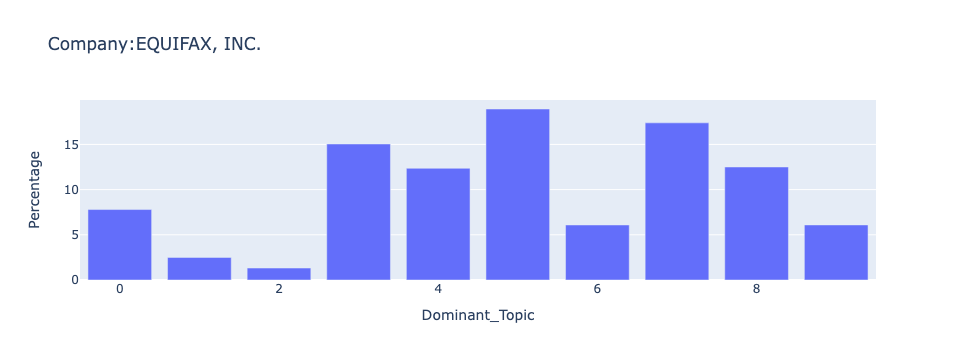

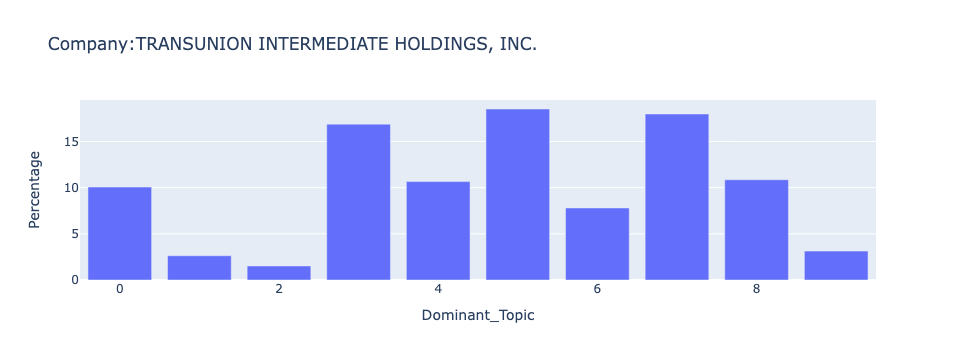

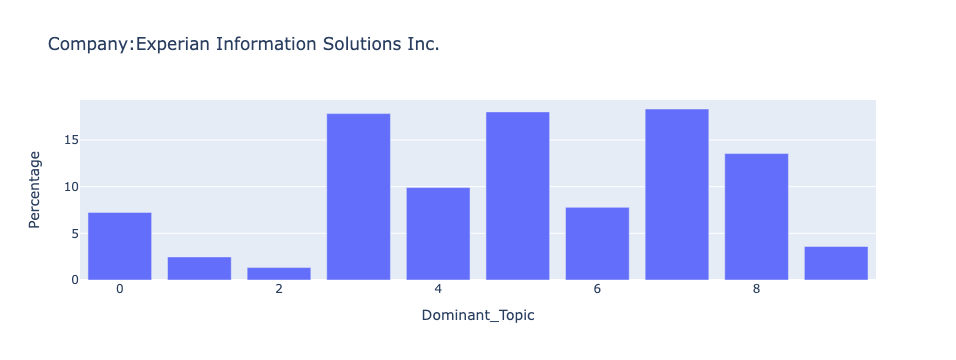

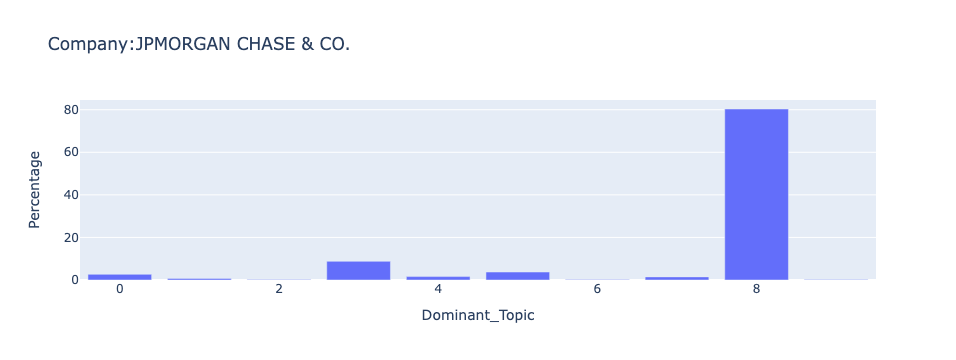

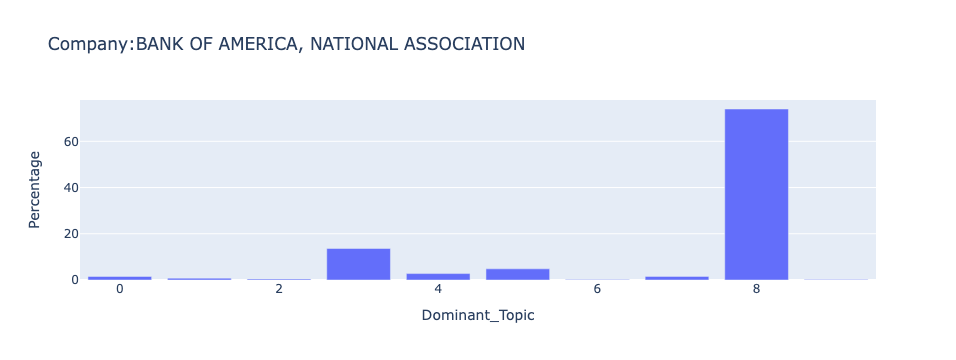

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ec2-user/anaconda3/envs/py

In [37]:
for i in list(df_company_Topic.Company.unique()):
    Company_df=df_company_Topic[df_company_Topic['Company']==i]
   
    fig=px.bar(Company_df,x='Dominant_Topic',y='Percentage',title=f'Company:{i}')
    fig.show() 

#### Let's then apply the model on unseen documents that we excluded from our training process.

In [34]:
%%time
#Produce the results for unseen model
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf_lem_5, corpus=corpus_test, texts=texts_test)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)
df_dominant_topic.to_csv('results on unseen documents.csv')

In [152]:
#Load the csv - run this if you want to load the result directly.
df_dominant_topic=pd.read_csv('results on unseen documents.csv')

In [138]:
%%time
#Make a copy of the test dataset and get it ready to merge with our topics modeling result
df_test1=df_test.copy()
df_test1.reset_index(inplace=True)
#Merge the topics to the original df test dataframe.
combined_unseen_documents=pd.merge(df_test1, df_dominant_topic, on=None, left_index=True,right_index=True)
#Save the result to csv
combined_unseen_documents.to_csv('combined_unseen_documents.csv')

CPU times: user 10.5 ms, sys: 10.9 ms, total: 21.4 ms
Wall time: 20.6 ms


#### Let's create a word cloud for each topic, based on the frequency of the word in each topic. The higher the frequency, the larger the size of the term.

#### Next, I am interested to learn more about how the terms and words change or evolve throughout  the period 2015 to 2022. We will leverage ldaseqmodel for this task.

In [34]:
# Due to limited computing resource, I only picked 2% of our training dataset for this analysis.
df_train_dtm=df_train.groupby(df_train['Date_received_dt'].dt.year).sample(frac=0.02, replace=False, random_state=42)

In [41]:
#save the sampled data
df_train_dtm.to_csv('sampled_train_ldaseq.csv')

In [21]:
index = pd.Index(df_train_dtm['Date_received_dt'].dt.year)
index.value_counts()  #time_stices should be changed based on counts

2022    2193
2021    1504
2020    1386
2019     845
2018     685
2017     657
2016     337
2015     237
Name: Date_received_dt, dtype: int64

In [22]:
data_clean_dtm = pd.DataFrame(df_train_dtm['Consumer complaint narrative'].apply(round1))
data_clean_dtm.head()

Consumer complaint narrative
Complaint ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1565911       transunion credit reporting agency has received from     on my    was submitted paidoff  of  my account number for this vehicle loan loan number       has reported this vehicle loan paid off for several months but transunion s efforts of attempting to compromise and prejudice my credit score as an    consumer retiree author activist advocate  veteran  fighter for justice for    as an federal agency would cfpb instruct transunion in showing my loan number   with     as paidoff also inform transunion of my goal of making them pay for continuous races and discriminatory practices against my  credit file in federal district court in   ga as soon as the va release my retroactive entitlements citing nearly a  dollars lastly transunion if you want to play let s play but at the end liabilities will be resolve  for  with my credit report do you get it again the balance of  auto loan with     was paidoff  of   and reported by     as transunion is very much aware i spoke with  and  with     in their reporting department statement is that they ve reported this vehicle as  being paid off in there  s transmission to the  bureaus transunion i m going to sue you  stop with the racism leave my credit file along i ll show you folks  transunion  in federal court i see what you  folks are attempting and notice i said attempting cfpb thanks for going after these crooks transunion i will keep fighting for justice for   as consumers
1619063                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        bank of america is inaccurately and incompletely furnishing information regardingthe one and only ba

In [25]:
#Save the list of words
data_dtm = data_clean_dtm['Consumer complaint narrative'].values.tolist()
data_words_dtm = list(sent_to_words(data_dtm))

print(data_words_dtm[:1][0][:30])

['transunion', 'credit', 'reporting', 'agency', 'has', 'received', 'from', 'on', 'my', 'was', 'submitted', 'paidoff', 'of', 'my', 'account', 'number', 'for', 'this', 'vehicle', 'loan', 'loan', 'number', 'has', 'reported', 'this', 'vehicle', 'loan', 'paid', 'off', 'for']


In [28]:
#Remove stopwords and convert to bigrams
data_words_nostops_dtm = remove_stopwords(data_words_dtm)
bigram_mod_dtm = bigrams(data_words_nostops_dtm)
bigrams_dtm = [bigram_mod_dtm[w] for w in data_words_nostops_dtm]

In [31]:
#lemmatization on bigrams
data_lemmatized_bigrams_dtm = lemmatization(bigrams_dtm, allowed_postags=['NOUN', 'ADJ'])
print(data_lemmatized_bigrams_dtm[:1][0][:30])

['transunion', 'credit', 'reporting', 'agency', 'paidoff', 'account', 'number', 'vehicle', 'loan', 'loan', 'number', 'vehicle', 'loan', 'several', 'month', 'transunion', 'effort', 'compromise', 'prejudice', 'credit', 'score', 'consumer', 'retiree', 'author', 'activist', 'advocate', 'veteran', 'fighter', 'federal', 'transunion']


In [40]:
#Save the bigrams
with open('data_lemmatized_bigrams_dtm.txt', 'w') as f:
    f.write(json.dumps(data_lemmatized_bigrams_dtm))

In [30]:
with open('data_lemmatized_bigrams_dtm.txt', 'r') as f:
    data_lemmatized_bigrams_dtm = json.loads(f.read())

In [31]:
id2word_dtm = corpora.Dictionary(data_lemmatized_bigrams_dtm)
id2word_dtm.filter_extremes(no_below=10, no_above=0.5)
id2word_dtm.compactify()
# Create Corpus
texts_dtm = data_lemmatized_bigrams_dtm

# Term Document Frequency
corpus_dtm = [id2word_dtm.doc2bow(text) for text in texts_dtm]

# View
print(corpus_dtm[:1][0][:30])
tfidf_dtm = TfidfModel(corpus_dtm)
corpus_tfidf_dtm = tfidf_dtm[corpus_dtm]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 5), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 9)]


In [37]:
#time_slice = [50,50,50,50,50,50,50,50]
time_slice=[237,337,657,685,845,1386,1504,2193]
years=[2015,2016,2017,2018,2019,2020,2021,2022]
num_topics = 10

In [38]:
%%time
ldaseq_test = ldaseqmodel.LdaSeqModel(corpus=corpus_tfidf_dtm, id2word=id2word_dtm, time_slice=time_slice, num_topics=num_topics)
ldaseq_test.save('ldaseq_test.model')
with open('ldaseq_test.pkl', 'wb') as f:
     pickle.dump(ldaseq_test, f)

/home/fangyf/.local/lib/python3.9/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/home/fangyf/.local/lib/python3.9/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
/home/fangyf/.local/lib/python3.9/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/home/fangyf/.local/lib/python3.9/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/home/fangyf/.local/lib/python3.9/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old 

CPU times: user 48min 48s, sys: 2min 39s, total: 51min 28s
Wall time: 48min 31s


In [28]:
model2 = 'ldaseq_test.pkl'
with open(model2, 'rb') as f:
    model2 = pickle.load(f)

In [32]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = model2.dtm_vis(time=0, corpus=corpus_tfidf_dtm)

In [33]:
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [10]:
#Turn topics into dataframe for future visualization
num_topics=10
topic_word_trend = pd.DataFrame()
for i in range(num_topics):
    result_topic=model2.print_topic_times(topic=i)
    df_result_topic=pd.DataFrame([t for lst in result_topic for t in lst[:5]])
    df_result_topic['Year']=(df_result_topic.index/5+2015).astype(int)
    df_result_topic['Topic']=str(i)
    topic_word_trend=topic_word_trend.append(df_result_topic,ignore_index=True)
topic_word_trend.rename(columns={0:'Term',1:'Frequency'},inplace=True)

In [127]:
#Turn topics into dataframe for future visualization
topic_word_trend = pd.DataFrame()
for i in range(num_topics):
    result_topic=model2.print_topic_times(topic=i)
    df_result_topic=pd.DataFrame([t for lst in result_topic for t in lst[:5]])
    df_result_topic['Year']=(df_result_topic.index/5+2015).astype(int)
    df_result_topic['Topic']=str(i)
    topic_word_trend=topic_word_trend.append(df_result_topic,ignore_index=True)
topic_word_trend.rename(columns={0:'Term',1:'Frequency'},inplace=True)

In [89]:
#Save the result for easier future visualization
topic_word_trend.to_csv('Dynamic_topic_model.csv')

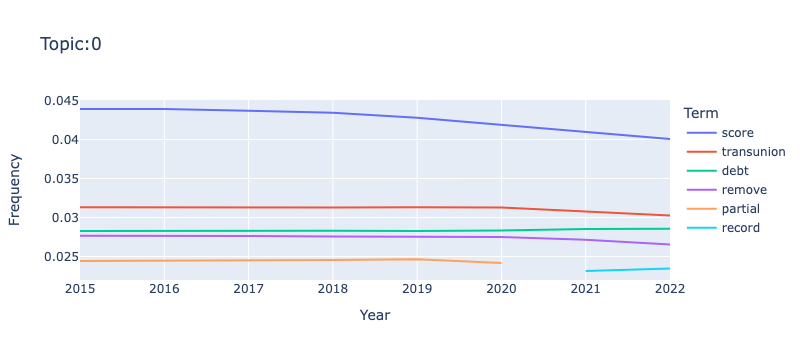

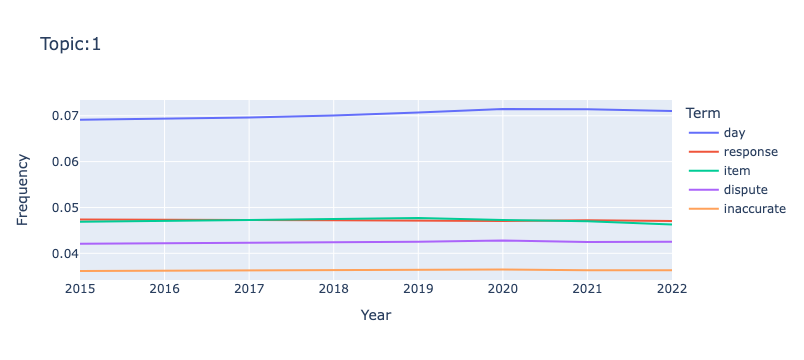

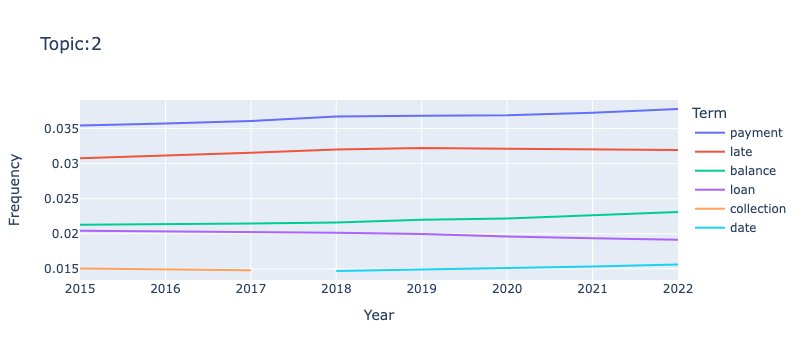

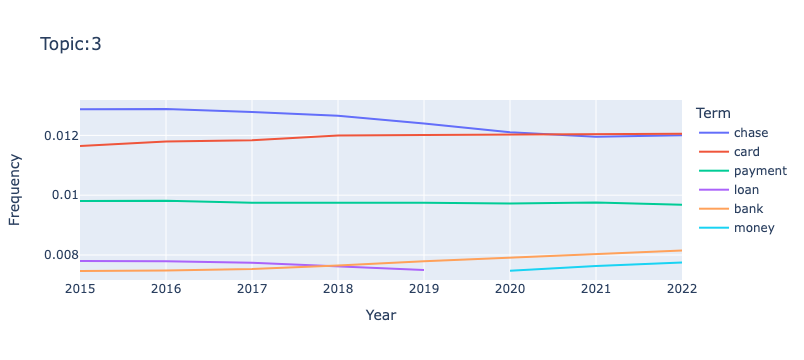

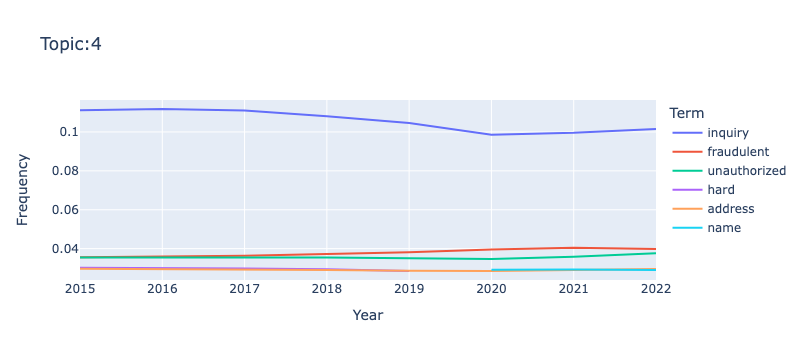

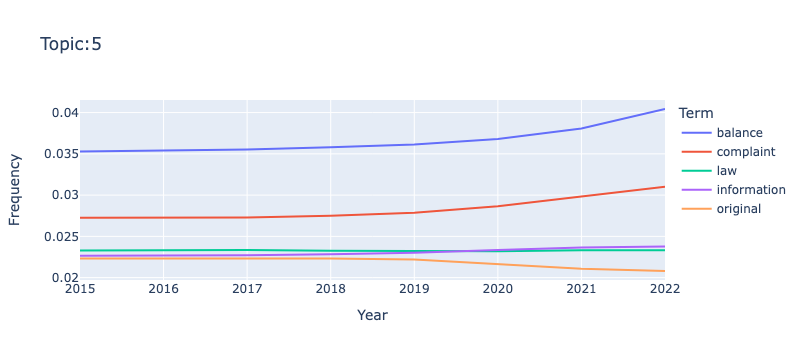

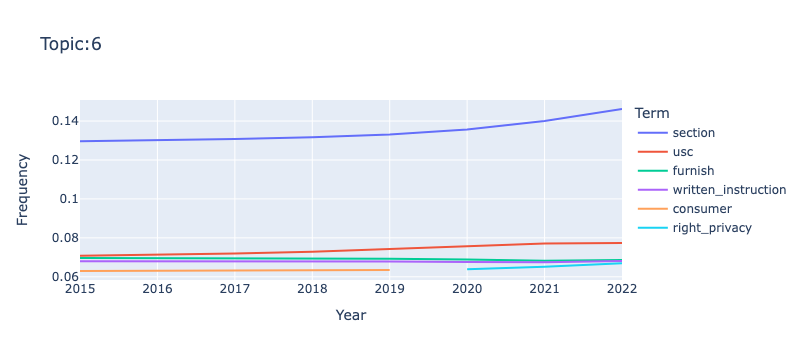

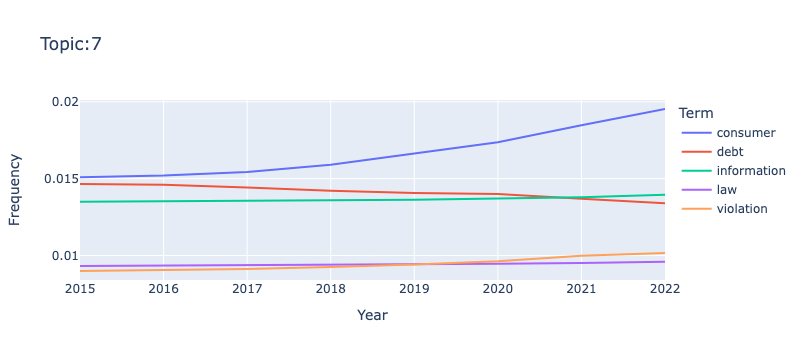

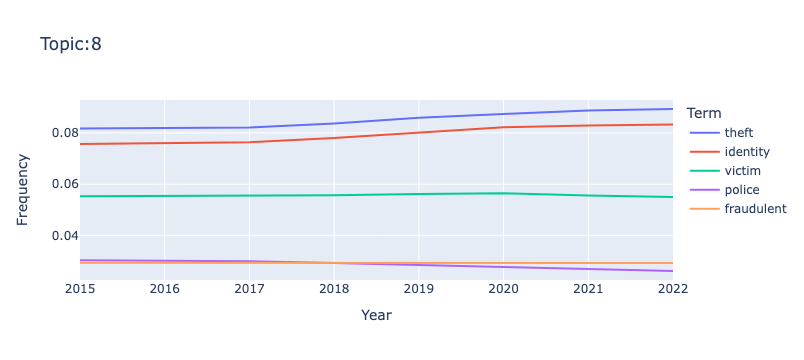

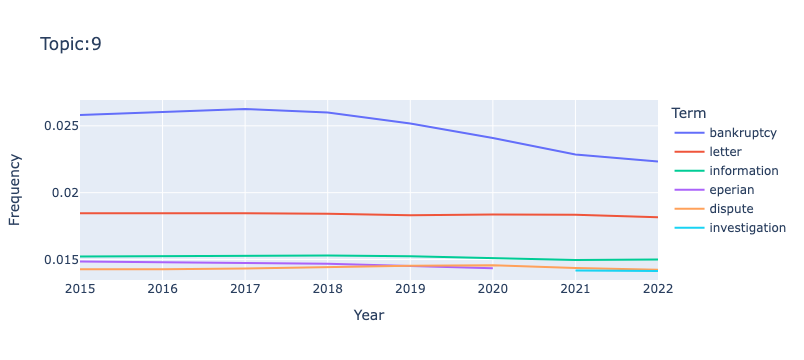

In [88]:
num_topics=10
for i in range(num_topics):
    topic_df=topic_word_trend[topic_word_trend['Topic']==str(i)]
    fig=px.line(topic_df,x=topic_df['Year'],y='Frequency',color='Term',title=f'Topic:{i}')
    fig.show()
    
    